# Segmentez des clients d'un site de e-commerce

## Notebook d'essais des approches de modélisation

J'importe les librairies nécessaires.

In [2]:
import pandas as pd 
from sklearn import cluster, metrics
from sklearn.preprocessing import StandardScaler 
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn import decomposition
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans 
from sklearn.cluster import DBSCAN
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
import numpy as np
import os

Je charge mon jeu de données cleané.

In [3]:
data = pd.read_csv("data.csv")
data.head()

,customer_unique_id,Recency,Frequency,Monetary,Average_review_score,Average_shopping_basket
0,0000366f3b9a7992bf8c76cfdf3221e2,1711,1,129.90,5.0,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1714,1,18.90,4.0,18.90
2,0000f46a3911fa3c0805444483337064,2137,1,69.00,3.0,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,1921,1,25.99,4.0,25.99
4,0004aac84e0df4da2b147fca70cf8255,1888,1,180.00,5.0,180.00


Je sépare mes données, d'un côté X la matrice de données.

In [4]:
X = data[data.columns[1:]].values
X[:5]

array([[1.711e+03, 1.000e+00, 1.299e+02, 5.000e+00, 1.299e+02],
       [1.714e+03, 1.000e+00, 1.890e+01, 4.000e+00, 1.890e+01],
       [2.137e+03, 1.000e+00, 6.900e+01, 3.000e+00, 6.900e+01],
       [1.921e+03, 1.000e+00, 2.599e+01, 4.000e+00, 2.599e+01],
       [1.888e+03, 1.000e+00, 1.800e+02, 5.000e+00, 1.800e+02]])

Je commence par scaler mes données et les transformer.

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled[:5]

array([[-0.83250272, -0.28814564, -0.0593038 ,  0.67668919,  0.01872465],
       [-0.81291639, -0.28814564, -0.56914752, -0.07703159, -0.56423091],
       [ 1.94875701, -0.28814564, -0.33902887, -0.83075237, -0.30111313],
       [ 0.53854081, -0.28814564, -0.53658183, -0.07703159, -0.52699528],
       [ 0.32309111, -0.28814564,  0.17081485,  0.67668919,  0.28184243]])

# <a name="C2"> K means </a>

J'instancie le modèle de clustering et le visualiser avec deux métriques différentes (où k est compris entre 2 et 10).

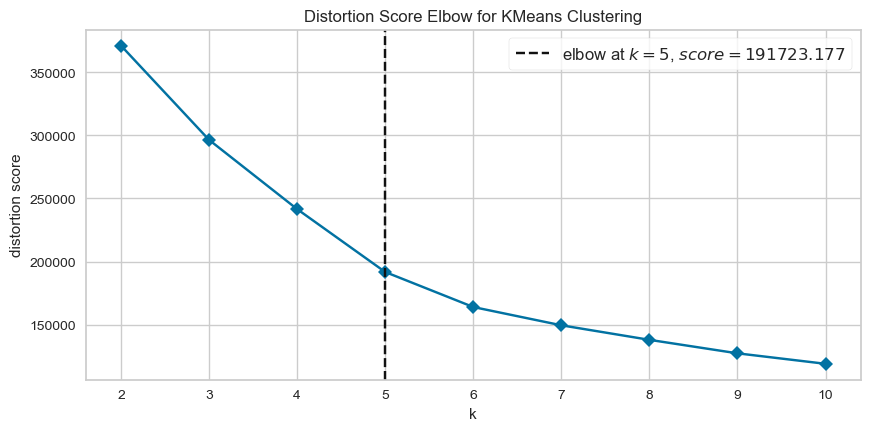

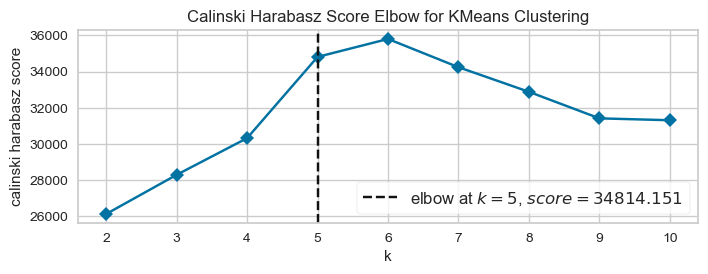

In [6]:
fig = plt.figure(figsize = (10, 10))
model = KMeans()

plt.subplot(211)
visualizer = KElbowVisualizer(model, k=(2, 11), timings=False)
visualizer.fit(X_scaled)
visualizer.poof()

plt.subplot(212)
visualizer = KElbowVisualizer(model, k=(2, 11), metric='calinski_harabasz', timings=False)
visualizer.fit(X_scaled)
visualizer.poof()

plt.show()

Selon les deux graphs, le nombre de clusters à choisir est 5. Je continue donc mon étude avec 5 clusters.

J'analyse le score de silhouette pour 5 clusters.

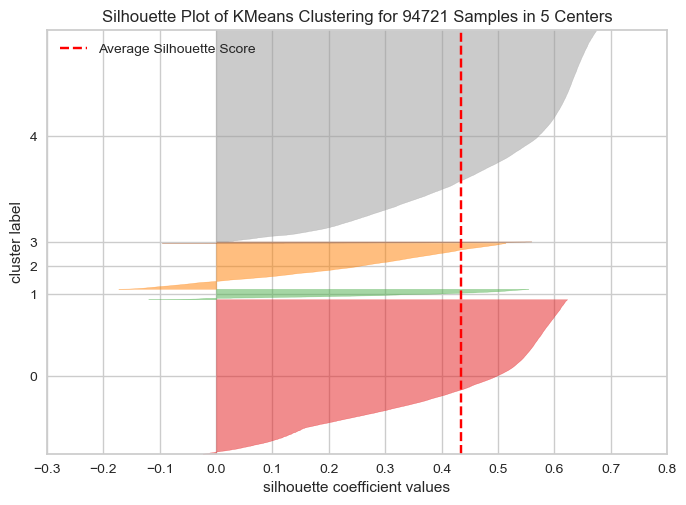

In [7]:
model = KMeans(5)
visualizer = SilhouetteVisualizer(model)
visualizer.fit(X)
visualizer.poof()
plt.show()

J'analyse quelques statistiques déscriptives (compte, moyenne, variance) sur la répartition de mes 5 clusters.

In [8]:
labels = model.fit_predict(X_scaled)
data_cluster = data.drop(columns = "customer_unique_id")
data_cluster.assign(Cluster = labels).groupby("Cluster").agg(["count", "mean", "var"]).T

Cluster                                   0             1             2  \
Recency                 count  31381.000000  41825.000000  15964.000000   
                        mean    1993.053058   1722.241291   1838.870521   
                        var     9012.031888   5304.947229  17146.033914   
Frequency               count  31381.000000  41825.000000  15964.000000   
                        mean       1.083968      1.083228      1.153846   
                        var        0.076920      0.076303      0.130186   
Monetary                count  31381.000000  41825.000000  15964.000000   
                        mean     109.331311    109.487165    120.836756   
                        var     9273.649373   9088.252419  11622.464668   
Average_review_score    count  31381.000000  41825.000000  15964.000000   
                        mean       4.632835      4.677418      1.649367   
                        var        0.353729      0.303981      0.702286   
Average_shopping_basket count  31381.000000  41825.000000  15964.000000   
                        mean     102.612416    102.529233    108.092070   
                        var     8058.756579   7818.091301   9555.930043   

Cluster                                    3             4  
Recency                 count    2520.000000   3031.000000  
                        mean     1844.938492   1835.715935  
                        var     24376.054572  22241.451624  
Frequency               count    2520.000000   3031.000000  
                        mean        1.108333      3.905312  
                        var         0.193499      2.716774  
Monetary                count    2520.000000   3031.000000  
                        mean     1067.104921    296.554230  
                        var    429503.381125  78312.912538  
Average_review_score    count    2520.000000   3031.000000  
                        mean        4.080985      3.607413  
                        var         1.934809      2.433201  
Average_shopping_basket count    2520.000000   3031.000000  
                        mean      992.501099     76.375854  
                        var    296059.313823   3672.953837

J'analyse la répartition de mes clusters à l'aide de boîtes à moustache. D'abord j'ajouyte une colonne avec les numéros des clusters.

In [34]:
data_cluster = data.drop(columns = "customer_unique_id")
data_cluster = data_cluster.assign(Cluster = labels)
data_cluster.head()

,Recency,Frequency,Monetary,Average_review_score,Average_shopping_basket,Cluster
0,1711,1,129.90,5.0,129.90,2
1,1714,1,18.90,4.0,18.90,2
2,2137,1,69.00,3.0,69.00,1
3,1921,1,25.99,4.0,25.99,1
4,1888,1,180.00,5.0,180.00,1


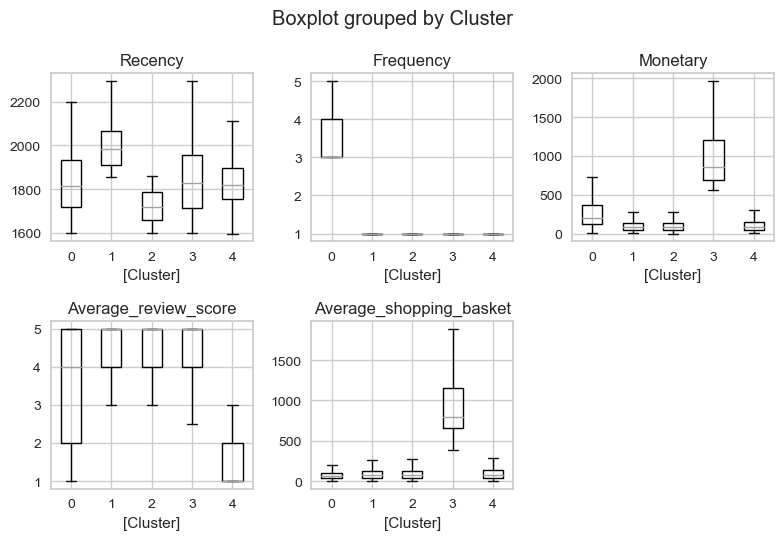

In [37]:
fig, axs = plt.subplots(2, 3)

r = data_cluster.loc[:, ["Recency", "Cluster"]]
r = pd.DataFrame(r)
r.boxplot(by="Cluster", ax = axs[0, 0], showfliers = False)

f = data_cluster.loc[:, ["Frequency", "Cluster"]]
f = pd.DataFrame(f)
f.boxplot(by = "Cluster", ax = axs[0, 1], showfliers = False)

m = data_cluster.loc[:, ["Monetary", "Cluster"]]
m = pd.DataFrame(m)
m.boxplot(by = "Cluster", ax = axs[0, 2], showfliers = False)

ars = data_cluster.loc[:, ["Average_review_score", "Cluster"]]
ars = pd.DataFrame(ars)
ars.boxplot(by = "Cluster", ax = axs[1, 0], showfliers = False)

asb = data_cluster.loc[:, ["Average_shopping_basket", "Cluster"]]
asb = pd.DataFrame(asb)
asb.boxplot(by = "Cluster", ax = axs[1, 1], showfliers = False)
fig.delaxes(axs[1,2])
plt.tight_layout() 

plt.show()

# <a name="C2"> Clustering hiérarchique </a>

Je commence par extraire un échantillon de ma matrice scalée X_scaled, travailler sur toutes mes données engendre des problèmes de mémoire.

In [38]:
X_scaled = pd.DataFrame(X_scaled)
data_reduit = X_scaled.sample(20000, random_state=42).copy()
data_reduit.rename(columns = {0:"Monetary", 1 : "Recency", 2 : "Frequency", 3 : "Average_review_score",
                              4 : "Average_shopping_basket"}, inplace = True)
data_reduit.head()

,Monetary,Recency,Frequency,Average_review_score,Average_shopping_basket
32638,-1.204643,-0.288146,-0.242572,-0.830752,-0.190824
23239,-0.199211,-0.288146,-0.518209,0.676689,-0.505988
86094,0.851922,-0.288146,-0.307336,-0.077032,-0.264875
16695,1.987930,-0.288146,-0.311470,-0.077032,-0.269602
51290,-1.002251,-0.288146,1.498292,-0.077032,1.799680


Je génère le dendrogramme entier.

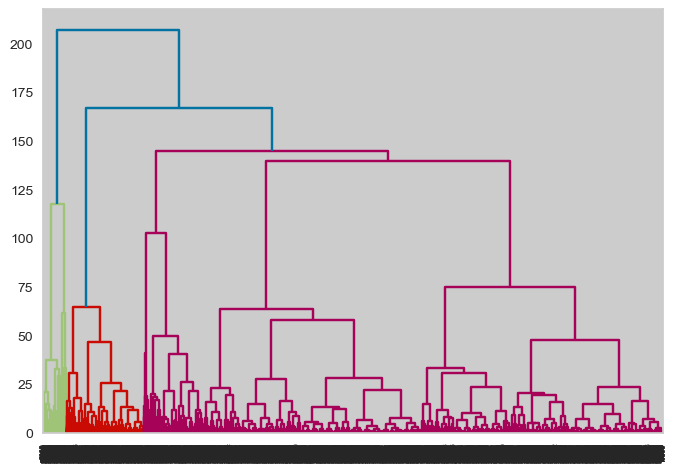

In [42]:
dend = hierarchy.dendrogram(hierarchy.linkage(data_reduit, method="ward"))

Je génère le dendrogramme tronqué pour plus de lisibilité.

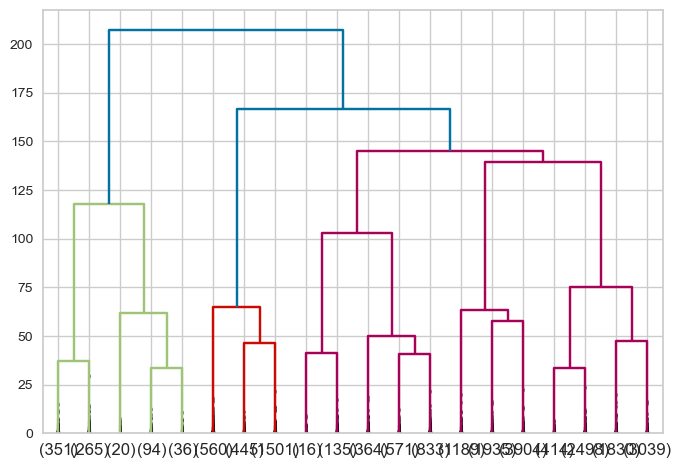

In [43]:
dend = hierarchy.dendrogram(hierarchy.linkage(data_reduit, method="ward"), truncate_mode="lastp",
                            p=20, show_contracted=True)

On obtient 3 clusters distincts. Je calcule le score de silhouette.

In [39]:
model = AgglomerativeClustering(n_clusters = 3)
model.fit(data_reduit)
print ("Le score de silhouette vaut: ", metrics.silhouette_score(data_reduit, model.labels_))

Le score de silhouette vaut:  0.3926706294045468


J'analyse quelques statistiques déscriptives (compte, moyenne, variance) sur la répartition de mes 3 clusters.

In [41]:
labels = model.fit_predict(data_reduit)
data_reduit.assign(Cluster = labels).groupby("Cluster").agg(["count", "mean", "var"]).T

Cluster                                   0           1            2
Monetary                count  16728.000000  766.000000  2506.000000
                        mean      -0.007716    0.014270     0.046191
                        var        1.030832    1.017544     0.845345
Recency                 count  16728.000000  766.000000  2506.000000
                        mean      -0.008802   -0.106467     0.194991
                        var        1.046916    0.454525     1.015910
Frequency               count  16728.000000  766.000000  2506.000000
                        mean      -0.144268    3.534061    -0.090113
                        var        0.220297    6.761209     0.249389
Average_review_score    count  16728.000000  766.000000  2506.000000
                        mean       0.328787   -0.079000    -2.186583
                        var        0.300557    1.221215     0.110850
Average_shopping_basket count  16728.000000  766.000000  2506.000000
                        mean      -0.151568    3.802144    -0.143177
                        var        0.166855    8.069565     0.182030

J'analyse la répartition de mes clusters à l'aide de boîtes à moustache.

In [43]:
data_cluster = data_reduit.assign(Cluster = labels)
data_cluster.head()

,Monetary,Recency,Frequency,Average_review_score,Average_shopping_basket,Cluster
32638,-1.204643,-0.288146,-0.242572,-0.830752,-0.190824,0
23239,-0.199211,-0.288146,-0.518209,0.676689,-0.505988,0
86094,0.851922,-0.288146,-0.307336,-0.077032,-0.264875,0
16695,1.987930,-0.288146,-0.311470,-0.077032,-0.269602,0
51290,-1.002251,-0.288146,1.498292,-0.077032,1.799680,0


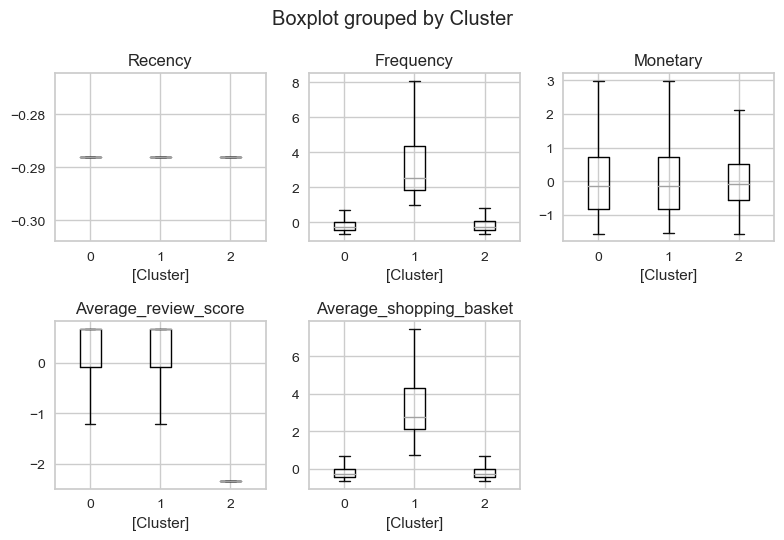

In [45]:
fig, axs = plt.subplots(2, 3)

r = data_cluster.loc[:, ["Recency", "Cluster"]]
r = pd.DataFrame(r)
r.boxplot(by="Cluster", ax = axs[0, 0], showfliers = False)

f = data_cluster.loc[:, ["Frequency", "Cluster"]]
f = pd.DataFrame(f)
f.boxplot(by = "Cluster", ax = axs[0, 1], showfliers = False)

m = data_cluster.loc[:, ["Monetary", "Cluster"]]
m = pd.DataFrame(m)
m.boxplot(by = "Cluster", ax = axs[0, 2], showfliers = False)

ars = data_cluster.loc[:, ["Average_review_score", "Cluster"]]
ars = pd.DataFrame(ars)
ars.boxplot(by = "Cluster", ax = axs[1, 0], showfliers = False)

asb = data_cluster.loc[:, ["Average_shopping_basket", "Cluster"]]
asb = pd.DataFrame(asb)
asb.boxplot(by = "Cluster", ax = axs[1, 1], showfliers = False)
fig.delaxes(axs[1,2])
plt.tight_layout() 

plt.show()

# <a name="C2"> DBSCAN </a>


Avant d'instancier le modèle, je dois trouver le epsilon optimal.

In [46]:
X_scaled = pd.DataFrame(X_scaled)
data_reduit = X_scaled.sample(20000, random_state=42).copy()
data_reduit.rename(columns = {0:"Monetary", 1 : "Recency", 2 : "Frequency", 3 : "Average_review_score",
                              4 : "Average_shopping_basket"}, inplace = True)
data_reduit.head()

,Monetary,Recency,Frequency,Average_review_score,Average_shopping_basket
32638,-1.204643,-0.288146,-0.242572,-0.830752,-0.190824
23239,-0.199211,-0.288146,-0.518209,0.676689,-0.505988
86094,0.851922,-0.288146,-0.307336,-0.077032,-0.264875
16695,1.987930,-0.288146,-0.311470,-0.077032,-0.269602
51290,-1.002251,-0.288146,1.498292,-0.077032,1.799680


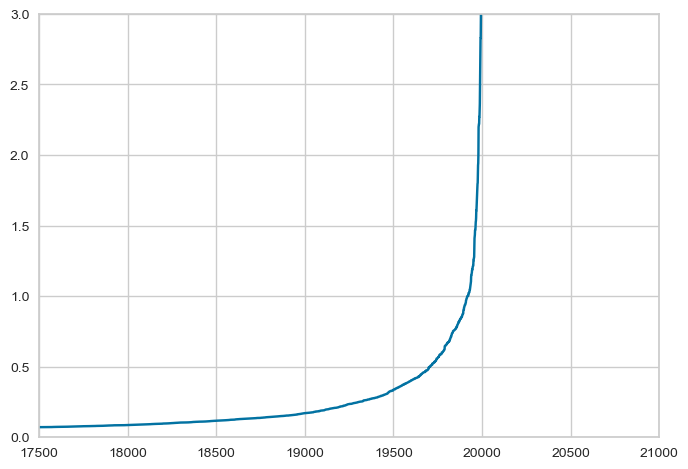

In [47]:
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(data_reduit)
distances, indices = nbrs.kneighbors(data_reduit)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.axis([17500, 21000, 0, 3])
plt.show()

Epsilon est optimal au point ou la tangente est maximale, je choisis eps = 1.5.

J'instancie le modèle et affiche le nombre de clusters trouvée.

In [49]:
model = DBSCAN(eps = 1.5, min_samples = 10)
labels = model.fit_predict(data_reduit)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print("Estimated number of clusters: %d" % n_clusters_)

Estimated number of clusters: 6


Je calcule le score de silhouette.

In [191]:
print ("Le score de silhouette vaut: ", metrics.silhouette_score(data_reduit, labels))

Le score de silhouette vaut:  0.23584314779020202


J'analyse quelques statistiques déscriptives (compte, moyenne, variance) sur la répartition de mes 3 clusters.
La colonne "-1" qui se créer contient les outliers (elle ne nous intéresse pas).

In [199]:
labels = model.fit_predict(data_reduit)
data_reduit.assign(Cluster = labels).groupby("Cluster").agg(["count", "mean", "var"]).T

Cluster                                -1             0            1  \
Monetary                count  132.000000  17407.000000  1827.000000   
                        mean     0.143500      0.001969    -0.030196   
                        var      1.269848      1.009425     0.976729   
Recency                 count  132.000000  17407.000000  1827.000000   
                        mean     4.397561     -0.288146     1.258137   
                        var     25.075820      0.000000     0.000000   
Frequency               count  132.000000  17407.000000  1827.000000   
                        mean     6.355554     -0.076569     0.140973   
                        var     17.156588      0.590194     0.471843   
Average_review_score    count  132.000000  17407.000000  1827.000000   
                        mean    -0.691111      0.043818    -0.269897   
                        var      1.665716      0.935124     1.296142   
Average_shopping_basket count  132.000000  17407.000000  1827.000000   
                        mean     4.569197     -0.001017    -0.207885   
                        var     32.682798      0.771599     0.154218   

Cluster                                2           3           4          5  
Monetary                count  58.000000  149.000000  382.000000  45.000000  
                        mean   -0.076628    0.172140   -0.043324  -0.113176  
                        var     0.864392    1.075956    0.949131   1.015641  
Recency                 count  58.000000  149.000000  382.000000  45.000000  
                        mean    5.896987    4.350704    2.804421   7.443270  
                        var     0.000000    0.000000    0.000000   0.000000  
Frequency               count  58.000000  149.000000  382.000000  45.000000  
                        mean    0.693029    0.637703    0.369454   0.621474  
                        var     0.526172    0.962711    0.549519   0.577432  
Average_review_score    count  58.000000  149.000000  382.000000  45.000000  
                        mean   -0.505873   -0.251551   -0.355237  -0.356187  
                        var     1.493234    1.168862    1.402030   1.641084  
Average_shopping_basket count  58.000000  149.000000  382.000000  45.000000  
                        mean   -0.355004   -0.293698   -0.272672  -0.420055  
                        var     0.027516    0.078663    0.079825   0.020970

J'analyse la répartition de mes clusters à l'aide de boîtes à moustache.

In [50]:
data_cluster = data_reduit.assign(Cluster = labels)
data_cluster.head()

,Monetary,Recency,Frequency,Average_review_score,Average_shopping_basket,Cluster
32638,-1.204643,-0.288146,-0.242572,-0.830752,-0.190824,0
23239,-0.199211,-0.288146,-0.518209,0.676689,-0.505988,0
86094,0.851922,-0.288146,-0.307336,-0.077032,-0.264875,0
16695,1.987930,-0.288146,-0.311470,-0.077032,-0.269602,0
51290,-1.002251,-0.288146,1.498292,-0.077032,1.799680,0


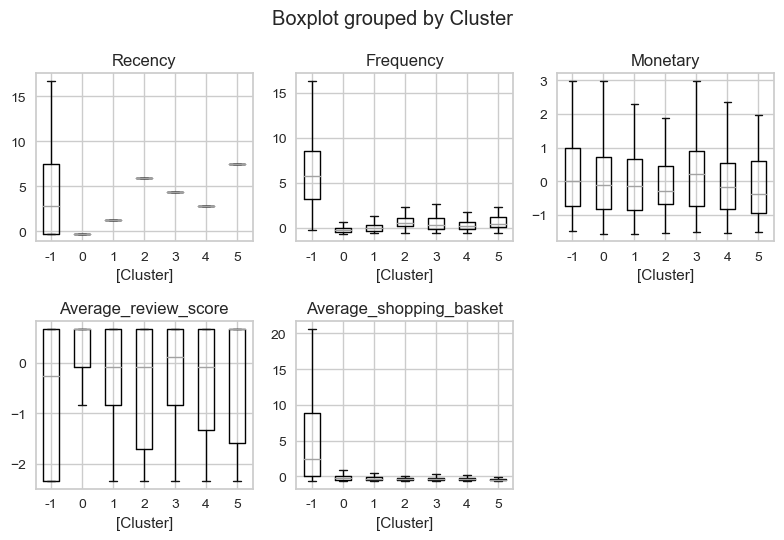

In [51]:
fig, axs = plt.subplots(2, 3)

r = data_cluster.loc[:, ["Recency", "Cluster"]]
r = pd.DataFrame(r)
r.boxplot(by="Cluster", ax = axs[0, 0], showfliers = False)

f = data_cluster.loc[:, ["Frequency", "Cluster"]]
f = pd.DataFrame(f)
f.boxplot(by = "Cluster", ax = axs[0, 1], showfliers = False)

m = data_cluster.loc[:, ["Monetary", "Cluster"]]
m = pd.DataFrame(m)
m.boxplot(by = "Cluster", ax = axs[0, 2], showfliers = False)

ars = data_cluster.loc[:, ["Average_review_score", "Cluster"]]
ars = pd.DataFrame(ars)
ars.boxplot(by = "Cluster", ax = axs[1, 0], showfliers = False)

asb = data_cluster.loc[:, ["Average_shopping_basket", "Cluster"]]
asb = pd.DataFrame(asb)
asb.boxplot(by = "Cluster", ax = axs[1, 1], showfliers = False)
fig.delaxes(axs[1,2])
plt.tight_layout() 

plt.show()

# <a name="C2"> Conclusion </a>


Kmeans : 5 clusters avec un score de silhouette de 0,44.

CAH : 3 clusters avec un score de silhouette de 0,39.

DBSCAN : 26 clusters avec un score de silhouette de 0,05.

Le modèle optimal est celui du KMeans avec 5 clusters.
Avec ce modèle, on obtient 5 catégories de clients: 
1) Les clients les plus anciens.

2) Les clients les moins satisfait.

3) Les clients qui dépensent le plus, avec un panier moyen plus élevé que les autres catégories de clients.

4) Les clients qui commandent le plus souvent.

5) Les clients "normaux".


Je réduis la dimension de mes données à l'aide d'une pca à 2 composantes puis à 3 composantes pour pouvoir représenter mes clusters dans un graph.

In [52]:
pca2 = decomposition.PCA(n_components = 2)
X_trans2 = pca2.fit_transform(X_scaled)

pca3 = decomposition.PCA(n_components = 3)
X_trans3 = pca3.fit_transform(X_scaled)

Je représente mes clusters en 2 et 3 dimensions.

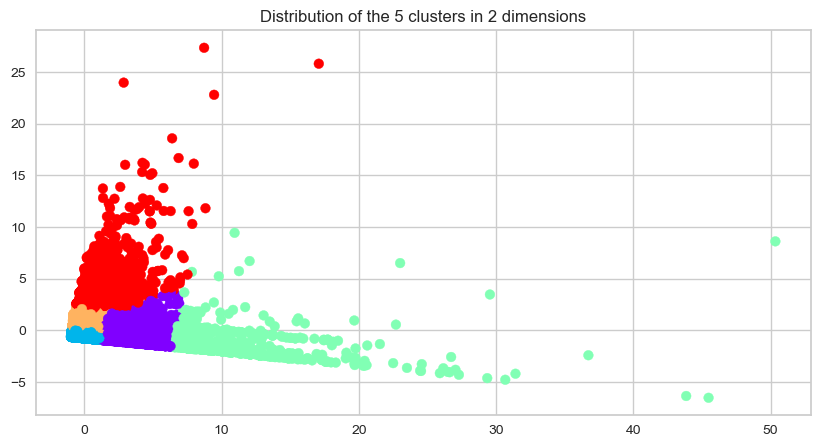

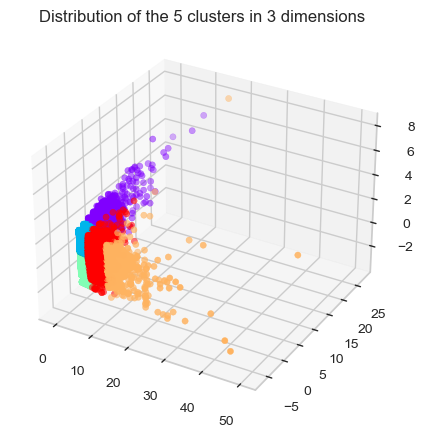

In [53]:
fig = plt.figure(figsize = (10, 5))
model = KMeans(5)

plt.scatter(X_trans2[:, 0], X_trans2[:, 1], c = model.fit_predict(X_trans2), cmap='rainbow')
plt.title("Distribution of the 5 clusters in 2 dimensions")
plt.show()

fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_trans3[:, 0], X_trans3[:, 1], X_trans3[:, 2], c = model.fit_predict(X_trans3), cmap='rainbow')
plt.title("Distribution of the 5 clusters in 3 dimensions")
plt.show()